In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

from sklearn import datasets

This notebook contains a demonstration how evaluation of boosting model with early-stopping can be set up in **Trava**.

### Get data

In [2]:
dataset = datasets.load_breast_cancer()
df = pd.DataFrame(dataset['data'], columns=dataset['feature_names'])
df['target'] = dataset['target']

### Setup scorers & results handlers

In [3]:
from sklearn.metrics import log_loss, roc_curve, roc_auc_score, recall_score, precision_score
from trava.ext.sklearn.scorers import sk, sk_proba
from trava.ext.results_handlers.metrics_dict import MetricsDictHandler

output_scorers = [
    sk_proba(log_loss),
    sk_proba(roc_auc_score),
    sk(recall_score),
    sk(precision_score)
]
output_handler = MetricsDictHandler(scorers=output_scorers)

### Split the data

In [4]:
from trava.ext.split_logic.basic import BasicSplitLogic
from trava.split.config import DataSplitConfig, SplitResultHandler
from trava.split.result import SplitResult
from trava.split.splitter import Splitter

split_config = DataSplitConfig(split_logic=BasicSplitLogic(shuffle=True),
                               target_col_name='target',
                               test_size=0.3,
                               valid_size=0.2) # validation set will be used as eval_set

split_result = Splitter.split(df=df, config=split_config)

### Setup Trava

In [5]:
from trava.trava_sv import TravaSV

trava = TravaSV(results_handlers=[output_handler])

### Playing with boosting evaluation

**EvalFitPredictor** is obviously a **FitPredictor** subclass. It sets up model's parameters for you by using provided eval_metric and number of early-stopping rounds. validation set from split_result will be used as eval_set. **EvalFitPredictor** also expects **EvalLogic** subclass for a particular model, since they work slightly different.

In [6]:
from trava.ext.boosting_eval.eval_steps import EvalFitSteps
from trava.fit_predictor import FitPredictor

eval_rounds = 3

[0]	validation_0-logloss:0.608689	validation_1-logloss:0.616602
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 3 rounds.
[1]	validation_0-logloss:0.54008	validation_1-logloss:0.557532
[2]	validation_0-logloss:0.48158	validation_1-logloss:0.507513
[3]	validation_0-logloss:0.43025	validation_1-logloss:0.464426
[4]	validation_0-logloss:0.38727	validation_1-logloss:0.426248
[5]	validation_0-logloss:0.349085	validation_1-logloss:0.395854
[6]	validation_0-logloss:0.315964	validation_1-logloss:0.369723
[7]	validation_0-logloss:0.287502	validation_1-logloss:0.349384
[8]	validation_0-logloss:0.261876	validation_1-logloss:0.33009
[9]	validation_0-logloss:0.2392	validation_1-logloss:0.311707
[10]	validation_0-logloss:0.218914	validation_1-logloss:0.298211
[11]	validation_0-logloss:0.200869	validation_1-logloss:0.282844
[12]	validation_0-logloss:0.182902	validation_1-logloss:0.269896
[13]	val

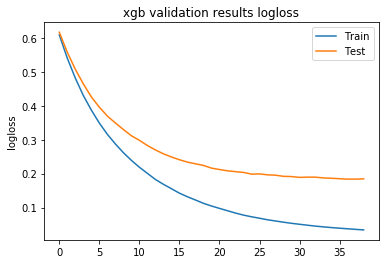

[{'xgb': {'test': {'log_loss': 0.046362519260127466,
    'roc_auc_score': 0.9995080555897184,
    'recall_score': 1.0,
    'precision_score': 0.9929577464788732},
   'other': {}}}]

In [7]:
from xgboost import XGBClassifier
from trava.ext.boosting_eval.xgboost_logic import XGBoostEvalLogic

eval_logic = XGBoostEvalLogic(needs_plot=True,
                              eval_metric='logloss',
                              early_stopping_rounds=eval_rounds)
fit_predictor = FitPredictor(steps=EvalFitSteps(eval_logic=eval_logic))
trava.fit_predict(raw_split_data=split_result,
                  model_id='xgb',
                  model_type=XGBClassifier,
                  fit_predictor=fit_predictor)

[1]	training's binary_logloss: 0.579804	valid_1's binary_logloss: 0.5771
Training until validation scores don't improve for 3 rounds
[2]	training's binary_logloss: 0.514641	valid_1's binary_logloss: 0.523281
[3]	training's binary_logloss: 0.462581	valid_1's binary_logloss: 0.481026
[4]	training's binary_logloss: 0.417138	valid_1's binary_logloss: 0.443183
[5]	training's binary_logloss: 0.378549	valid_1's binary_logloss: 0.411846
[6]	training's binary_logloss: 0.344074	valid_1's binary_logloss: 0.382775
[7]	training's binary_logloss: 0.314902	valid_1's binary_logloss: 0.359247
[8]	training's binary_logloss: 0.288319	valid_1's binary_logloss: 0.339227
[9]	training's binary_logloss: 0.26567	valid_1's binary_logloss: 0.321304
[10]	training's binary_logloss: 0.244611	valid_1's binary_logloss: 0.304585
[11]	training's binary_logloss: 0.226963	valid_1's binary_logloss: 0.291143
[12]	training's binary_logloss: 0.208355	valid_1's binary_logloss: 0.276379
[13]	training's binary_logloss: 0.192218

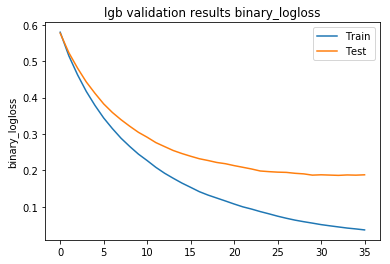

[{'lgb': {'test': {'log_loss': 0.05128542198295308,
    'roc_auc_score': 0.9997540277948592,
    'recall_score': 1.0,
    'precision_score': 0.9929577464788732},
   'other': {}}}]

In [8]:
from lightgbm import LGBMClassifier
from trava.ext.boosting_eval.lightgbm_logic import LightGBMEvalLogic

eval_logic = LightGBMEvalLogic(needs_plot=True,
                               eval_metric='logloss',
                               early_stopping_rounds=eval_rounds)

fit_predictor = FitPredictor(steps=EvalFitSteps(eval_logic=eval_logic))
trava.fit_predict(raw_split_data=split_result,
                  model_id='lgb',
                  model_type=LGBMClassifier,
                  fit_predictor=fit_predictor)

Learning rate set to 0.025239
0:	learn: 0.6451243	test: 0.6515092	best: 0.6515092 (0)	total: 59.7ms	remaining: 59.6s
1:	learn: 0.6077809	test: 0.6204071	best: 0.6204071 (1)	total: 61.2ms	remaining: 30.5s
2:	learn: 0.5714471	test: 0.5883413	best: 0.5883413 (2)	total: 63ms	remaining: 20.9s
3:	learn: 0.5409571	test: 0.5633864	best: 0.5633864 (3)	total: 64.3ms	remaining: 16s
4:	learn: 0.5126726	test: 0.5374417	best: 0.5374417 (4)	total: 65.6ms	remaining: 13.1s
5:	learn: 0.4844944	test: 0.5154268	best: 0.5154268 (5)	total: 67.2ms	remaining: 11.1s
6:	learn: 0.4534618	test: 0.4893589	best: 0.4893589 (6)	total: 68.5ms	remaining: 9.72s
7:	learn: 0.4306828	test: 0.4702041	best: 0.4702041 (7)	total: 69.8ms	remaining: 8.65s
8:	learn: 0.4028827	test: 0.4456942	best: 0.4456942 (8)	total: 71.2ms	remaining: 7.84s
9:	learn: 0.3830713	test: 0.4292426	best: 0.4292426 (9)	total: 72.6ms	remaining: 7.19s
10:	learn: 0.3635213	test: 0.4148210	best: 0.4148210 (10)	total: 73.9ms	remaining: 6.65s
11:	learn: 0.34

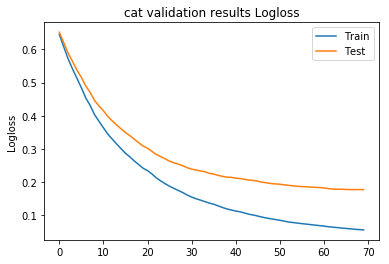

[{'cat': {'test': {'log_loss': 0.06251236339898839,
    'roc_auc_score': 0.9998770138974296,
    'recall_score': 1.0,
    'precision_score': 0.9929577464788732},
   'other': {}}}]

In [9]:
from trava.ext.boosting_eval.catboost_logic import CatBoostEvalLogic
from catboost import CatBoostClassifier

eval_logic = CatBoostEvalLogic(needs_plot=True,
                               early_stopping_rounds=eval_rounds)

fit_predictor = FitPredictor(steps=EvalFitSteps(eval_logic=eval_logic))
trava.fit_predict(raw_split_data=split_result,
                  model_id='cat',
                  model_type=CatBoostClassifier,
                  model_init_params={'eval_metric': 'Logloss'},
                  fit_predictor=fit_predictor)

In [10]:
trava.results

[{'xgb': {'test': {'log_loss': 0.046362519260127466,
    'roc_auc_score': 0.9995080555897184,
    'recall_score': 1.0,
    'precision_score': 0.9929577464788732},
   'other': {}},
  'lgb': {'test': {'log_loss': 0.05128542198295308,
    'roc_auc_score': 0.9997540277948592,
    'recall_score': 1.0,
    'precision_score': 0.9929577464788732},
   'other': {}},
  'cat': {'test': {'log_loss': 0.06251236339898839,
    'roc_auc_score': 0.9998770138974296,
    'recall_score': 1.0,
    'precision_score': 0.9929577464788732},
   'other': {}}}]